# Solutions for Lab Sheet 5 (COM3502-4502-6502 Speech Processing)

This lab sheet (solution) is part of the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield").

It is probably easiest to open this Jupyter Notebook with [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true "Open in Google Colab") since GitHub's Viewer does not always show all details correctly. <a href="https://colab.research.google.com/github/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheet-Solutions/Lab-Sheet-5-Solution.ipynb"><img align="right" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open Notebook in Google Colab" title="Open and Execute the Notebook directly in Google Colaboratory"></a>

Please put questions, comments and correction suggestions in the [Blackboard](https://vle.shef.ac.uk) discussion board or send an email to [s.goetze@sheffield.ac.uk](mailto:s.goetze@sheffield.ac.uk).

In [1]:
# Let's do the ususal necessary and nice-to-have imports
%matplotlib inline
import matplotlib.pyplot as plt  # plotting
import seaborn as sns; sns.set() # styling (uncomment if you want)
import numpy as np               # math

## Loading a Speech File

Let's download a wave file containing speech:

In [2]:
# download speech and noise example files
s_file_name = 'speech_8kHz_murder.wav'
!curl https://staffwww.dcs.shef.ac.uk/people/S.Goetze/sound/{s_file_name} -o {s_file_name} 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  328k  100  328k    0     0  1532k      0 --:--:-- --:--:-- --:--:-- 1536k


As done before several times by now, we can load the file from hard-disc to a variable and play it back (if we like).

In [3]:
import soundfile as sf
from IPython import display as ipd

# load speech wave into variable
s, fs = sf.read(s_file_name)

print('File "' + s_file_name + '" loaded. Its sampling rate is ' + str(fs) + ' Hz.')

# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

File "speech_8kHz_murder.wav" loaded. Its sampling rate is 8000 Hz.


## Spectrogram (Task 1)

The spectrogram can be used to visualise time and frequency information at the same time. The `specgram()` command from `matplotlib` has optional parameters, e.g. for the FFT length. Have a look at the [documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.specgram.html) to familarise yourself with the parameters.

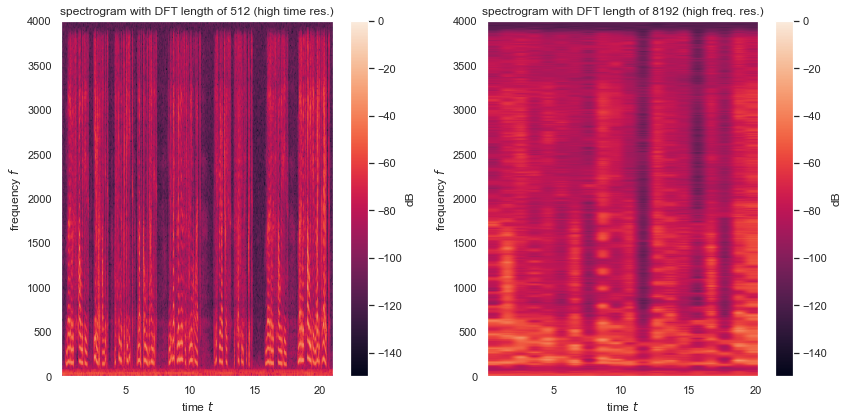

In [4]:
# visualise
fig=plt.figure(figsize=(12,6)) # create a figure of size 12 x 6 inches

LDFT=512

plt.subplot(1,2,1)
plt.specgram(s, Fs=fs, NFFT=LDFT); # NFFT default: 256
plt.title('spectrogram with DFT length of ' + str(LDFT) + ' (high time res.)')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None) # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-150,0)


LDFT=8192

plt.subplot(1,2,2)
plt.specgram(s, Fs=fs, NFFT=LDFT); # NFFT default: 256
plt.title('spectrogram with DFT length of ' + str(LDFT) + ' (high freq. res.)')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None)  # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-150,0)

plt.tight_layout()

The spectrograms above visualise the same soeech signal, but for the left one, a smaller DFT length (or FFT length in this case) was chosen, i.e. less samples per analysis block. This leads to a higher resolution in time direction than for the spectrogram in the right panel. Temporal structure can be better analysed in the spectrogram in the left panel while spectral information (such as the resonances (light horizontal lines in right panel)) are more prominent in the right spectrogram.

## Filtering by Piece-wise Linear Filters (Task 2)

We want to design digital filters in the following as depited below:

<img src="https://staffwww.dcs.shef.ac.uk/people/S.Goetze/book/Chp2Fundamentals/images/FilteringIIRfilter-web.svg" align="center"/>

The figure above shows the schamatic of an [IIR filter](https://en.wikipedia.org/wiki/Infinite_impulse_response "Open Wikipedia for more details on IIR filters if you are intrested.").

This can be described mathematically by the difference equation for recursive filters 

\begin{equation}
y[k] = \sum_{m=0}^{q} b_m \; x[k-m] + \sum_{n=1}^{p} a_n \; y[k-n].
\end{equation}

The actual filter coefficients $a_n$, for $0 \leq n \leq p$ and $b_m$, for $0 \leq m \leq q$ can be obtained by different filter design methods.

In the following, we exemplarily design
* a [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter "More info on the Butterworth filter can be found on Wikipedia")
* a [Chebyshev I filter](https://en.wikipedia.org/wiki/Chebyshev_filter "More info on the Chebyshev I and II filters can be found on Wikipedia")  
* a Chebyshev II filter and
* an [Eliptic filter](https://en.wikipedia.org/wiki/Elliptic_filter "More info on the Eliptic filter can be found on Wikipedia").

### Tolerance Scheme

We want to design a piece-wise linear filter, such as a [low-pass](https://en.wikipedia.org/wiki/Low-pass_filter), [band-pass](https://en.wikipedia.org/wiki/Band-pass_filter), [high-pass](https://en.wikipedia.org/wiki/High-pass_filter) or similar, we want such a filter to at least fullfill the following conditions:

*   It should be 1 or close to one in the pass-band area
*   It should be zero or close to zero in the stop band area

The following function `plot_tolerance_scheme()` is a helper function which visualises such a tolerance scheme. 

In [5]:
def plot_tolerance_scheme(Wp=0.25,Ws=0.3,Rp_lin=0.9,Rs_lin=0.1):
    """
    Plots a tolerance scheme for a (low-pass) filter design.
    
    Parameters
    ----------
    Wp : float, optional (but recommended)
        pass limit frequency (normalised) $W_p = \Omega / \pi$
    Ws : float, optional (but recommended)
        stop limit frequency (normalised)
    Rp_lin : float, optional (but recommended)
        allowed ripple range in pass band (linear), default 0.9
    Rs_lin : float, optional (but recommended)
        allowed ripple range in pass band (linear), default 0.1

    Example use:
    -------
    signal
        plot_tolerance_scheme(Wp=0.25,Ws=0.3,Rp_lin=0.9,Rs_lin=0.1)
    """
    dh1x=[0,Ws];  dh1y=[1,1];            # (x,y) coordinates of lines
    dh2x=[0,Wp];  dh2y=[Rp_lin,Rp_lin]; 
    dv2x=[Wp,Wp]; dv2y=[0,Rp_lin];   
    sh1x=[Ws,1];  sh1y=[Rs_lin,Rs_lin]; 
    sh2x=[Wp,1];  sh2y=[0,0]; 
    svx=[Ws,Ws];  svy=[Rs_lin,1];  
    # plot the actual lines
    plt.plot(dh1x,dh1y,'k--',dh2x,dh2y,'k--',dv2x,dv2y,'k--',sh1x,sh1y,'k--',
             sh2x,sh2y,'k--',svx,svy,'k--');
    plt.xlabel('Frequency $\Omega/\pi$');

The following conditions are visualised in the tolerance scheme below for the exmample values $W_p=0.25$, $W_s=0.3$, and allowing for 10% ripples both in stop band area as in pass band area. The allowed tolerance is the pass-band area is defined by the parameter `Rp_lin`, and allowed tolerance is the stop-band area by `Rs_lin`. Please note, that they have the ending `..._lin` since we will need these quantities later in logarithmic scaling (we will care for this then). 

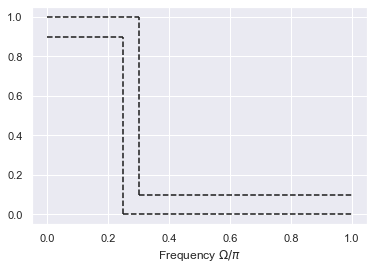

In [6]:
Wp=0.25;    # passband edge frequency 
Ws=0.3;     # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area

plot_tolerance_scheme(Wp,Ws,Rp_lin,Rs_lin)

Please note that the low pass tolerance scheme is given in terms of normalised frequency $\Omega$.

As a reminder, we are already familiar with three different notations for the frequency, i.e. 
* the technical frequency $f$ in Hz, which for ditital signals and systems should be bound by half of the sampling frequency $f_s$ to fullfil the [Nyquist-Shannon Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem) to avoid [aliasing](https://en.wikipedia.org/wiki/Aliasing), i.e. $-\frac{f_s}{2} \leq f \leq \frac{f_s}{2}$
* the [angular frequency](https://en.wikipedia.org/wiki/Angular_frequency) $\omega = 2 \pi f$ 
* the [normalised frequency](https://en.wikipedia.org/wiki/Normalized_frequency_(unit)) $\Omega = \frac{\omega}{f_s} = 2 \pi \frac{f}{f_s}$ which is then bound by $0 \leq \Omega \leq 2 \pi$ or, since the frequency response is periodic for digital signals, $- \pi \leq \Omega \leq \pi$.

The parameters $W_p$ and $W_s$ are closely related to the normalised frequency $\Omega$, i.e. for $W_p=0.25$ it results in $\Omega_p=0.25 \pi$.

The slightly changed tolerance scheme which should be created for Task 2 of [Lab-Sheet 5](https://github.com/sap-shef/SpeechProcesssingLab/blob/main/Lab-Sheets/Lab-Sheet-5.ipynb "Open Lab Sheet 5") looks like this:

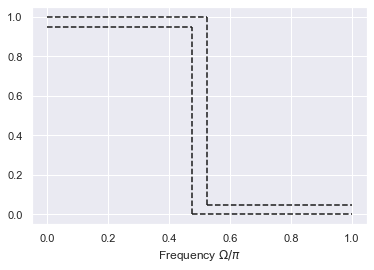

In [7]:
Wp=0.475;    # passband edge frequency 
Ws=0.525;     # stopband edge frequency 
Rp_lin=0.95; # allowed ripples in the pass band area
Rs_lin=0.05; # allowed ripples in the stop band area

plot_tolerance_scheme(Wp,Ws,Rp_lin,Rs_lin)

### Zero-Pole Plot (Transfer Functuon of Filters in z-Domain)

Applying a $z$-transform to the difference equation $z$-domain transfer function $H[z]$ of the filter leads to

\begin{equation}
H[z] = \frac{Y[z]}{X[z]} = \frac{\sum_{m=0}^{M} b_m \, z^{-m}}{\sum_{n=0}^{N} a_n \, z^{-n}}
\end{equation}

The transfer function can also be extpressed in term of the positions of its $P$ zeros $z_{0,\mu}$, ($1 \leq \mu \leq P$) and  its $Q$ poles $z_{\infty,\nu}$, ($1 \leq \nu \leq Q$). 


\begin{equation}
H[z] = \frac{b_M}{a_N} \cdot \frac{\prod_{\mu=1}^{P} (z - z_{0,\mu})^{m_\mu}}{\prod_{\nu=1}^{Q} (z - z_{\infty,\nu})^{n_\nu}}
\end{equation}

For speech and audio processing, systems often have real-valued coefficients $b_m\in\mathbb{R}$ and $a_n\in\mathbb{R}$ which results in a real-valued system. For real-valued systems, poles and zeros are either real valued or occur in complex conjugate pairs.

For the poles of a *causal* and *stable* system $H[z]$ all poles have to lie within the unit circle, i.e. $|z| = 1$. 

The following code implements another helper-function `zplane()` which plots poles and zeros in the complex $z$-plane.

In [8]:
def zplane(z, p, title='Poles and Zeros'):
    "Plots zeros and poles in the complex z-plane"
    ax = plt.gca()

    ax.plot(np.real(z), np.imag(z), 'bo', fillstyle='none', ms=10)
    ax.plot(np.real(p), np.imag(p), 'rx', fillstyle='none', ms=10)
    unit_circle = plt.Circle((0, 0), radius=1, fill=False,
                             color='black', ls='--', alpha=0.9)
    ax.add_patch(unit_circle)

    plt.title(title)
    plt.xlabel('Re{$z$}')
    plt.ylabel('Im{$z$}')
    plt.axis('equal')

The code below exemplarily shows two (comjugate complex) zeros at positions $z_{0,1}= -0.9$ and $z_{0,2} = 0.8$ (indicated by the blue circles) as well as a poles at positions $z_{\infty,1}=0.5 + 0.5j$ and $z_{\infty,2}=0.5 - 0.5j$ (indicated by the red crosses)  in the $z$ plane. The code above is a helper-function to plot the zeros and poles.

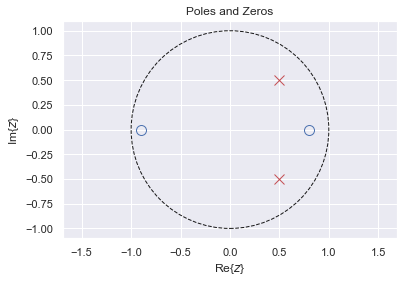

In [9]:
poles = [0.5-0.5j, 0.5+0.5j] # two (comjugate complex) poles
zeros = [-0.9, 0.8]          # two (real-valued) zeros
zplane(zeros,poles)

### Butterworth Filter Design  (Task 3)

To actually design a filter we can use then function `butter()` from `scipy`'s `signal` library which calculates filter coefficients $a_n$ and $b_m$. 

To ensure that our tolerace scheme is fullfilled we have to know, how many coefficients $a_n$, for $0 \leq n \leq p$ and $b_m$, for $0 \leq m \leq q$ (as defined below the schematic depicted at the top of this Notebook) the `butter()` method needs to achieve this. If we assume to have as many coefficients forward coefficients $b_m$ as feedback path coefficients $a_n$, i.e. $p=q$ we define the order of the filter as being $p$ (or $q$). The function `buttord()` takes our tolerance scheme (values) and calculates to required filter order $N$. Furthermore, the function `buttord()` returns the [cut-off frequnecy](https://en.wikipedia.org/wiki/Cutoff_frequency) of the filter, a.k.a. natural frequency and therefore the variable name `Wn` is used below (if we would denote this frequency by $f_c$ this would lead to confusion with the center frequency $f_c$. The cut-off frequency is defined as the frequency at which the frequency response is decayed by $3$ dB ($=1/\sqrt{2} \approx 0.71$).

In [10]:
from scipy import signal         # filter designs (if not already imported)

Wp=0.25;    # passband edge frequency 
Ws=0.3;     # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area

# the ripple hights in dB are needed in later cells of this Jupyter Notebook 
Rp=-20*np.log10(Rp_lin);  # max passband ripple in dB
Rs=-20*np.log10(Rs_lin);  # min stopband attenuation in dB

# get lowest filter order N to fullfill requirements above
N, Wn = signal.buttord(Wp, Ws, Rp, Rs)

print('The minimum possible filter order to fulfil the tolerance scheme is '+str(N)+'.')
print('The cut-off frequency which will be {:.2f}.'.format(Wn)) # format number - two digits after decimal pt.

The minimum possible filter order to fulfil the tolerance scheme is 15.
The cut-off frequency which will be 0.26.


We have now all information to design the filter.

In [11]:
# design low-pass filter of order N using butterworth method
b, a = signal.butter(N, Wn, 'low')

#print(b)
#print(a)

We can use the `freqz()` functions from `scipy`'s `signal`-processing library, which calculated the transfer function in frequency domain $h(f)$ for us. We can also calculate the frequency response without using `freqz()` by exploiting <sup>[[DSP]](https://www.dsprelated.com/freebooks/filters/Frequency_Response_Analysis.html)</sup>.

\begin{equation}
h(e^{j \Omega}) = \frac{\mathrm{DFT}\{\mathbf{b}\}}{\mathrm{DFT}\{\mathbf{a}\}}
\end{equation}

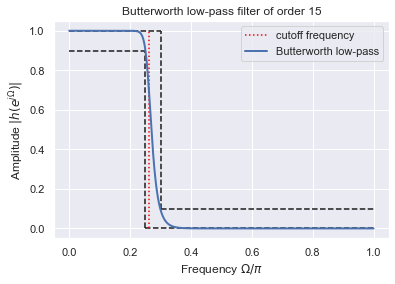

In [12]:
f,h=signal.freqz(b,a)
omega=np.linspace(0,1,len(f))

# the following code does actually the same as the freqz command:
#h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
#h=h[0:513] # only show first half (positive frequencies)
#omega=np.linspace(0,1,513)

# plot frequency response
plot_tolerance_scheme(Wp,Ws,Rp_lin,Rs_lin)
plt.plot([Wn,Wn],[0,1],color='red',ls=':',label='cutoff frequency')
plt.plot(omega,np.abs(h), lw=2, label='Butterworth low-pass')
plt.title('Butterworth low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$')
plt.legend();

To see the corresponding poles and zeros, we can convert the coefficients to zeros and poles using `numpy`'s `roots()` function.

Please note: We don't calculate the roots of the coefficients $b_m$ to obtain the positions of the zeros for the following plot. The Butterworth filter theory shows that all zeros are at $z=-1$ and the `roots()` function would introduce some calculation errors showing the zeros not exactly at $z=-1$.

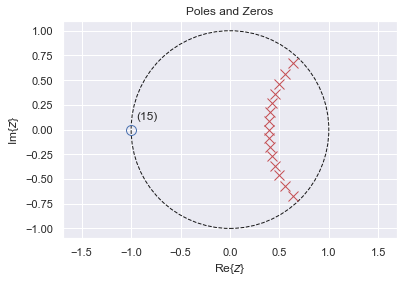

In [13]:
# plot zeros and poles in the z plane
zplane(-1, np.roots(a))
plt.text(-0.95,0.1,'('+str(N)+')'); # adding text with info how many zeros are located a z=-1

Task 3 (changing the slope / transition frequency) is solved as follows:

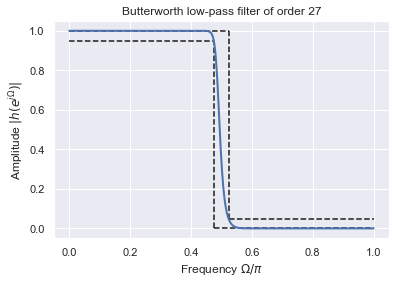

In [14]:
wp=0.475;    # passband edge frequency 
ws=0.525;     # stopband edge frequency 
Rp_lin=0.95; # allowed ripples in the pass band area
Rs_lin=0.05; # allowed ripples in the stop band area

# the ripple hights in dB are needed in later cells of this Jupyter Notebook 
Rp=-20*np.log10(Rp_lin);  # max passband ripple in dB
Rs=-20*np.log10(Rs_lin);  # min stopband attenuation in dB

# get lowest filter order N to fullfill requirements above
N, Wn = signal.buttord(wp, ws, Rp, Rs)
# design low-pass filter of order N using butterworth method
b, a = signal.butter(N, Wn, 'low')

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

# plot frequency response
plot_tolerance_scheme(wp,ws,Rp_lin,Rs_lin)
plt.plot(omega, abs(h), lw=2)
plt.title('Butterworth low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$');

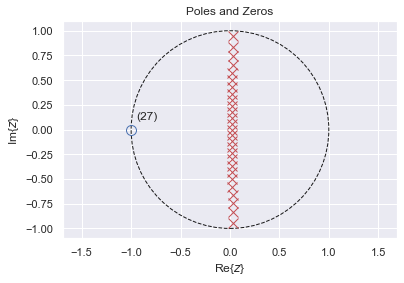

In [15]:
# plot zeros and poles in the z plane
zplane(-1, np.roots(a))
plt.text(-0.95,0.1,'('+str(N)+')');

### Filtering (Task 4)

The function `filtfilt(b, a, s)` from `scipy`'s `signal` library realises a filter.

In [16]:
s_filtered = signal.filtfilt(b, a, s)

We can compare the signal $s[k]$ before and after filtering. The plots generated by the following code show the signal before after applying the filter (left panel) and the same signals again (right panel; just zoomed in x-axis (time-)direction). 

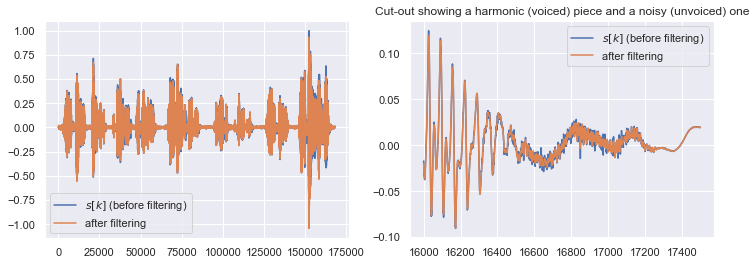

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1) # plot signal before and after filtering in time domain
plt.plot(s,label='$s[k]$ (before filtering)')
plt.plot(s_filtered,label='after filtering')
plt.legend()

plt.subplot(1,2,2) # zoom into the signal 
start_idx=16000
end_idx=start_idx+1500
plt.plot(np.arange(start_idx,end_idx),s[start_idx:end_idx],label='$s[k]$ (before filtering)')
plt.plot(np.arange(start_idx,end_idx),s_filtered[start_idx:end_idx],label='after filtering')
plt.title('Cut-out showing a harmonic (voiced) piece and a noisy (unvoiced) one')
plt.legend();

The left panel shows that we can see slight changes in the signal, comparing it before and after filtering. However, it appears that not much has happened to the signal. If we take a more detailed look at a part between samples $16,000$ and $17,500$ (right panel) which shows a periodic (voiced) part at the beginning of this cut-out), then a noisy part (rather unvoiced) and the (at the end) another transition into a less noisy part, we observe more changes for the noisy part in the middle of the right panel. 

Listening to the original and filtered signal like realised in the following reveals that the low-pass effect is clearly perceivable.

In [18]:
# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

In [19]:
# listen to the sound file (if you want)
ipd.Audio(s_filtered, rate=fs)

Since speech has most of its energy in the low frequency range, most of the energy is still preserverd (thus similar time domain plots above). If we calculate the spectograms (code below), we clearly see that the high frequencies are missing after filtering (right panel of plot below). High frequencies mean fast oscillations in the time domain signal, which should explain, why the noisy part in the time domain plot above is more affected.

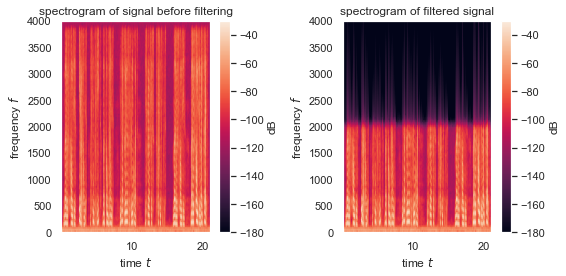

In [20]:
# visualise as spectrograms
fig=plt.figure(figsize=(8,4)) # create a figure of size 12 x 6 inches

plt.subplot(1,2,1)
plt.specgram(s, Fs=fs)
plt.title('spectrogram of signal before filtering')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None) # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-180,-30) # select the 'color'/amplitude range (in dB)

plt.subplot(1,2,2)
plt.specgram(s_filtered, Fs=fs)
plt.title('spectrogram of filtered signal')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None)  # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-180,-30)

plt.tight_layout() # to see all axis descriptions

### Chebyshev I and Chebyshev II filter design (Task 5)

Chebyshev filter designs make better use of the tolerance scheme by allowing for ripples in the pass band (Chebyshev I filter design) or stop band (Chebyshev II filter design), respectively. By this, the number of necessary filter coefficients $N$ can be reduced in comparison to the Butterworth filter.

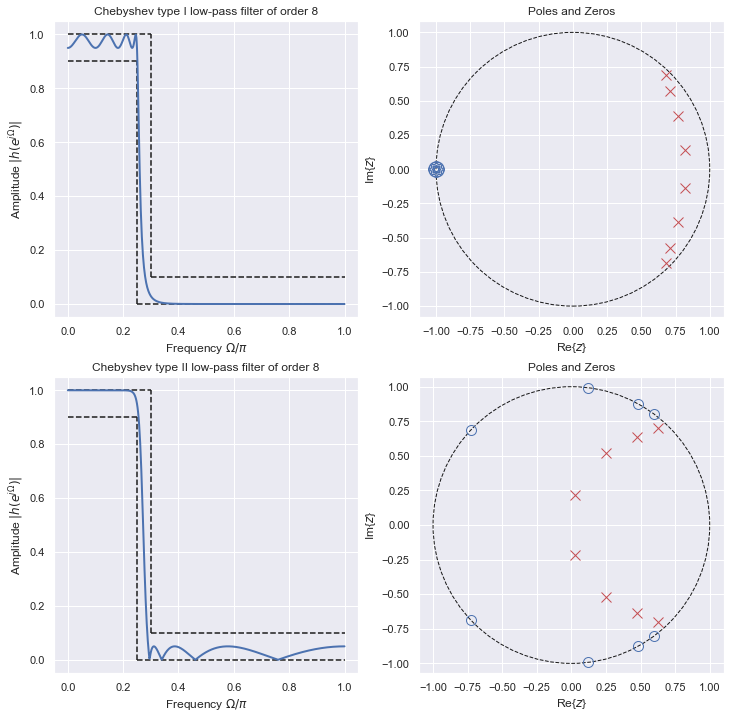

In [21]:

wp=0.25;    # passband edge frequency 
ws=0.3;     # stopband edge frequency 
Rp_lin=0.9; # allowed ripples in the pass band area
Rs_lin=0.1; # allowed ripples in the stop band area


# get lowest filter order N to fullfill requirements above
N, Wn = signal.cheb1ord(wp, ws, Rp, Rs)
# design low-pass filter of order N using butterworth method
b, a = signal.cheby1(N, Rp, Wn, 'low')

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

plt.figure(figsize=(12, 12))

# plot frequency response
plt.subplot(2,2,1)
plot_tolerance_scheme()
plt.plot(omega, abs(h), lw=2)
plt.title('Chebyshev type I low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$')
#plt.show()

# plot zeros and poles in the z plane
plt.subplot(2,2,2)
zplane(np.roots(b), np.roots(a))

# get lowest filter order N to fullfill requirements above
N, Wn = signal.cheb2ord(wp, ws, Rp, Rs)
# design low-pass filter of order N using butterworth method
b, a = signal.cheby2(N, Rs, Wn, 'low')

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

# plot frequency response
plt.subplot(2,2,3)
plot_tolerance_scheme()
plt.plot(omega, abs(h), lw=2)
plt.title('Chebyshev type II low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$')
#plt.show()

# plot zeros and poles in the z plane
plt.subplot(2,2,4)
zplane(np.roots(b), np.roots(a))

We can apply the filter again and analyse the spectrograms before and after filtering.

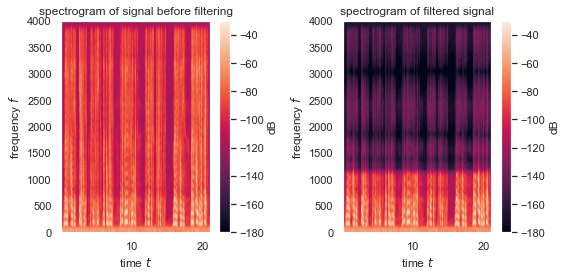

In [22]:
s_filtered = signal.filtfilt(b, a, s)


# visualise as spectrograms
fig=plt.figure(figsize=(8,4)) # create a figure of size 12 x 6 inches

plt.subplot(1,2,1)
plt.specgram(s, Fs=fs)
plt.title('spectrogram of signal before filtering')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None) # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-180,-30)

plt.subplot(1,2,2)
plt.specgram(s_filtered, Fs=fs)
plt.title('spectrogram of filtered signal')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None)  # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-180,-30)

plt.tight_layout() # to see all axis descriptions

In the spectrograms above the ripples of the Chebyshev II filter design caused by the three zeros on the unit circle are clearly visible in the right panel.

### Cauer Filter a.k.a. Elliptical Filter Design (Task 6)

The number of necessary filter coefficients $N$ can be further reduced in comparison to the Butterworth, and Chebyshev I and II filters by allowing ripples in both, pass- and stop-band. This is done by the Cauer filter.

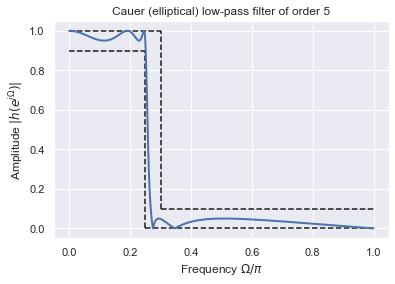

In [23]:
# get lowest filter order N to fullfill requirements above
N, Wn = signal.ellipord(wp, ws, Rp, Rs)
# design low-pass filter of order N using butterworth method
b, a = signal.ellip(N, Rp, Rs, Wn, 'low')

h=np.abs(np.fft.fft(b,1024))/np.abs(np.fft.fft(a,1024));
h=h[0:513] # only show first half (positive frequencies)
omega=np.linspace(0,1,513)

# plot frequency response
plot_tolerance_scheme()
plt.plot(omega, abs(h), lw=2)
plt.title('Cauer (elliptical) low-pass filter of order ' + str(N))
plt.ylabel('Amplitude $|h(e^{j \Omega})|$')
plt.show()

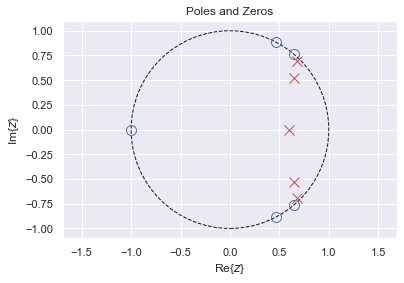

In [24]:
# plot zeros and poles in the z plane
zplane(np.roots(b), np.roots(a))

### Band pass and plotting in dB (Task 7)

Filters (especially for processing speech or music) are usually not only designed with logarithmic amplitude in mind, but also plotted with linear amplitude. The filter design methods can also be used to design other piece-wise linear filter, e.g. a band-pass.

Let's first define the desired characteristics and determine the order necessary to design the filter.

In [46]:
Wp = [0.25, 0.5]       # pass-band frequency limits (normalised)
Ws = [0.2,  0.6]       # stop-band frequency limits (normalised)
Rp = 1                 # we allow 1 dB ripple in pass-band
Rs = 40                # we's like to have 40dB attenuation
Rs_lin= 10**(-Rs/20)   # transforming dB back to linear
Rp_lin= 10**(-Rp/20)   # transforming dB back to linear

# determine necessary filter order as well as cut-off frequencies
N, Wn = signal.buttord(Wp, Ws, Rp, Rs)
print('The minimum possible filter order to fulfil the tolerance scheme is '+str(N)+'.')
print('The 1st cut-off frequency which will be {:.2f}.'.format(Wn[0])) 
print('The 2nd cut-off frequency which will be {:.2f}.'.format(Wn[1])) 

The minimum possible filter order to fulfil the tolerance scheme is 11.
The 1st cut-off frequency which will be 0.24.
The 2nd cut-off frequency which will be 0.51.


Now we can design and analyse the filter.

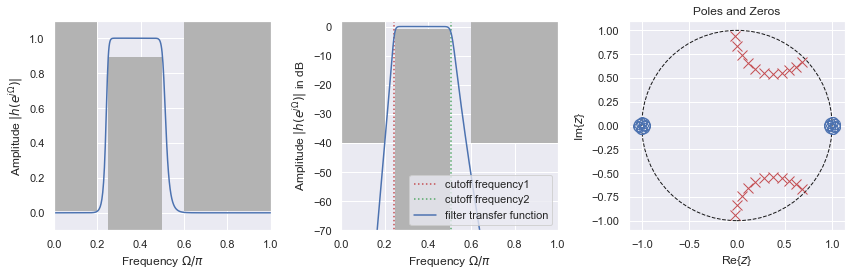

In [47]:
# design filter
b, a = signal.butter(N, Wn, 'band')

# create frequency response
f,h=signal.freqz(b,a)
omega=np.linspace(0,1,len(f))

# plot filter
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(omega, np.abs(h))
#plt.title('Butterworth bandpass filter fit to constraints')
plt.ylabel('Amplitude $|h(e^{j \Omega})|$')
plt.xlabel('Frequency $\Omega / \pi$')
plt.grid(True,which='both', axis='both')

plt.fill([0,     Ws[0], Ws[0], 0],     [Rs_lin, Rs_lin, 1.1, 1.1], '0.7', lw=0) # stop
plt.fill([Wp[0], Wp[0], Wp[1], Wp[1]], [-.1, Rp_lin, Rp_lin, -.1], '0.7', lw=0) # pass
plt.fill([Ws[1], Ws[1], 1, 1],         [1.1, Rs_lin, Rs_lin, 1.1], '0.7', lw=0) # stop
plt.axis([0, 1, -0.1, 1.1]);

# plot filter again (this time in dB)
plt.subplot(1,3,2)
plt.plot([Wn[0],Wn[0]],[-100,2],color='r',ls=':',label='cutoff frequency1')
plt.plot([Wn[1],Wn[1]],[-100,2],color='g',ls=':',label='cutoff frequency2')
plt.plot(omega, 20*np.log10(np.abs(h)),label='filter transfer function')
plt.ylabel('Amplitude $|h(e^{j \Omega})|$ in dB')
plt.xlabel('Frequency $\Omega / \pi$')
plt.legend(loc='lower right')
plt.fill([0,     Ws[0],  Ws[0],   0],    [-Rs, -Rs, 2, 2],       '0.7', lw=0) # stop
plt.fill([Wp[0], Wp[0],  Wp[1],  Wp[1]], [-100, -Rp, -Rp, -100], '0.7', lw=0) # pass
plt.fill([Ws[1], Ws[1], 1, 1],           [2, -Rs, -Rs, 2],       '0.7', lw=0) # stop
plt.axis([0, 1, -70, 2]);

# plot zeros and poles in the z plane
plt.subplot(1,3,3)
zplane(np.roots(b), np.roots(a))

plt.tight_layout()

We can apply the filter again and analyse the spectrograms before and after filtering.

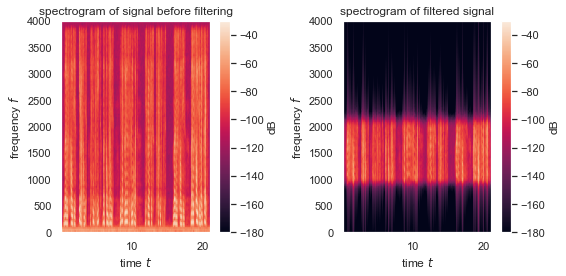

In [48]:
s_filtered = signal.filtfilt(b, a, s)

# visualise as spectrograms
fig=plt.figure(figsize=(8,4)) # create a figure of size 12 x 6 inches

plt.subplot(1,2,1)
plt.specgram(s, Fs=fs)
plt.title('spectrogram of signal before filtering')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None) # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-180,-30)

plt.subplot(1,2,2)
plt.specgram(s_filtered, Fs=fs)
plt.title('spectrogram of filtered signal')
plt.xlabel('time $t$')
plt.ylabel('frequency $f$')
plt.grid(None)  # no grid (in case you used seaborn)

plt.colorbar(label='dB');
plt.clim(-180,-30)

plt.tight_layout() # to see all axis descriptions

In [49]:
# listen to the sound file (if you want)
ipd.Audio(s, rate=fs)

In [50]:
# listen to the sound file (if you want)
ipd.Audio(s_filtered, rate=fs)

## Copyright

This notebook is licensed to be used during the lecture COM[3502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level3/com3502.html "Open web page for COM3502 module")-[4502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/level4/com4502.html "Open web page for COM4502 module")-[6502](http://www.dcs.shef.ac.uk/intranet/teaching/public/modules/msc/com6502.html "Open web page for COM4502 module") Speech Processing at the [University of Sheffield](https://www.sheffield.ac.uk/ "Open web page of The University of Sheffield"), Dept. of [Computer Science](https://www.sheffield.ac.uk/dcs "Open web page of Department of Computer Science, University of Sheffield"). Any further use (beyond use for the lecture) is only permitted if agreed with the [module lead](mailto:s.goetze@sheffield.ac.uk). 